# Forecasting interpretation

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/tinkoff-ai/etna/master?filepath=examples/10-forecasting_interpretation.ipynb)

This notebook contains examples of forecast decomposition into additive components for various models.

**Table of contents**

* [Loading dataset](#chapter1)
* [Forecast decomposition](#chapter2)
    * [CatBoost](#chapter2_1)
    * [SARIMAX](#chapter2_2)
    * [BATS](#chapter2_3)
    * [In-sample and out-of-sample decomposition](#chapter2_4)
* [Accessing target components](#chapter3)
* [Regressors relevance](#chapter4)
    * [Feature relevance](#chapter4_1)
    * [Components relevance](#chapter4_2)

**Required extensions**: None

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
from copy import deepcopy

import pandas as pd

from etna.analysis import plot_backtest
from etna.analysis import plot_forecast_decomposition
from etna.datasets import TSDataset
from etna.metrics import MAE
from etna.pipeline import Pipeline
from etna.transforms import LagTransform

In [3]:
HORIZON = 21

## 1. Loading dataset <a class="anchor" id="chapter1"></a>

Consider the dataset `data/example_dataset.csv`.

We will use this data to demonstrate how model forecasts can be decomposed down to additive effects in the ETNA library.

Let's load and plot this data to get a brief idea of how time series look.

In [4]:
df = pd.read_csv("data/example_dataset.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq="D")

ts.head(5)

segment    segment_a segment_b segment_c segment_d
feature       target    target    target    target
timestamp                                         
2019-01-01       170       102        92       238
2019-01-02       243       123       107       358
2019-01-03       267       130       103       366
2019-01-04       287       138       103       385
2019-01-05       279       137       104       384

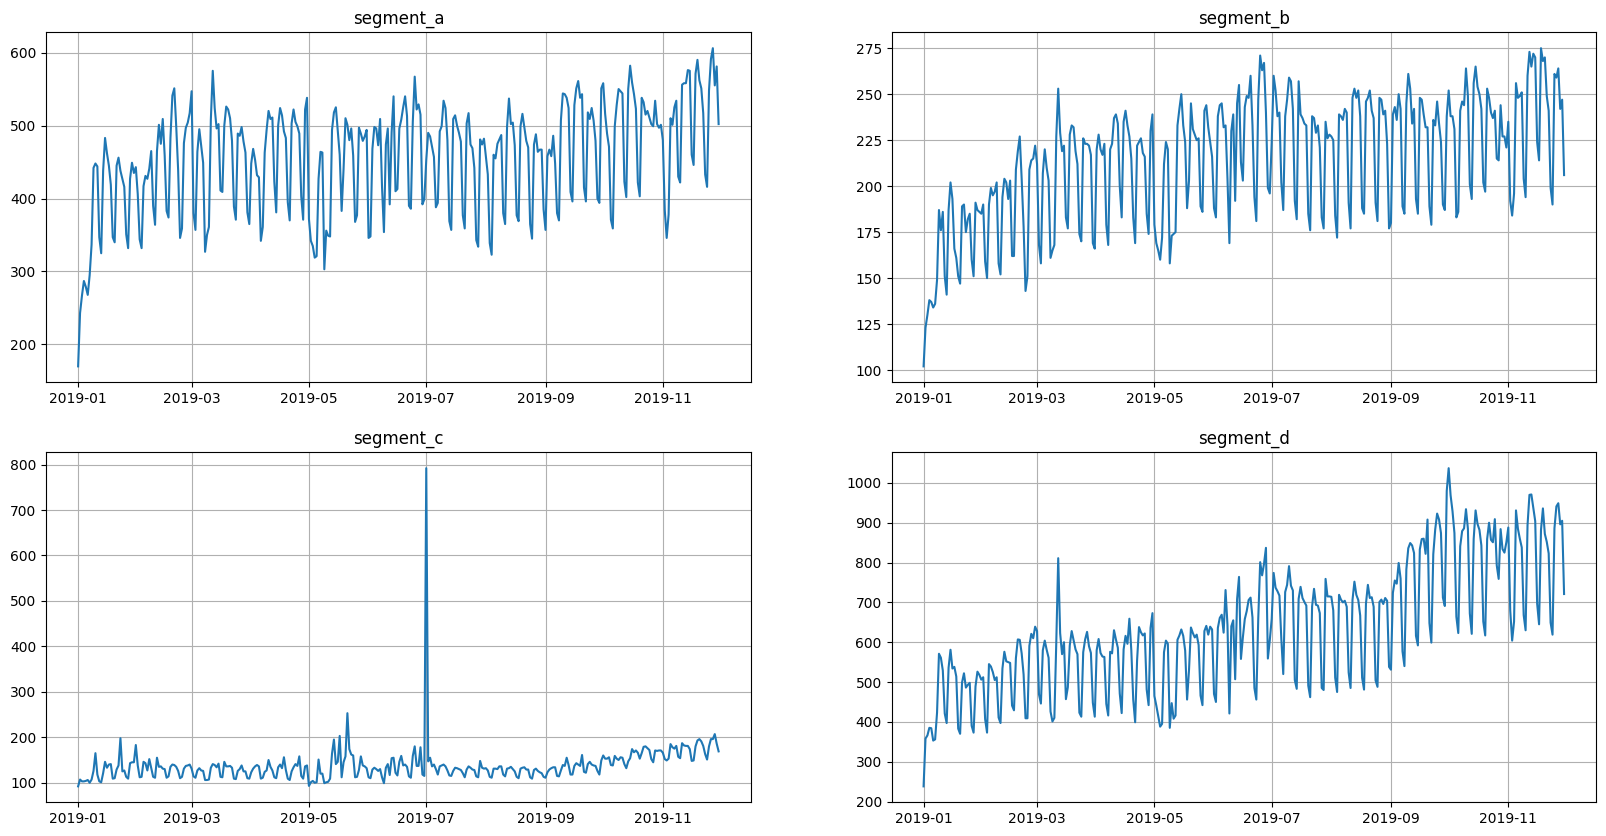

In [5]:
ts.plot()

Here we have four segments in the dataset. All segments have seasonalities, and some of them show signs of trend.

Some of the models need features in order to estimate forecasts. Here we will use lags of the target variable as
features when it is necessary.

In [6]:
transforms = [
    LagTransform(in_column="target", lags=list(range(21, 57, 7)), out_column="lag"),
]

## 2. Forecast decomposition <a class="anchor" id="chapter2"></a>

This section shows how a model forecast can be decomposed down to individual additive components.
There are two types of decomposition:
* model-specific decomposition
* model-agnostic decomposition

**Model-specific** decomposition uses model representation to compute components. Consider linear regression as an example.
$\hat y = w^T X + b$. We can slightly rewrite this equation to see additive components $\hat y = \sum_{i=0}^m w_i x_i + b$.
So in this case, the components are: $w_i x_i$ and $b$.

**Model-agnostic** decomposition uses separate estimators to compute the contribution of each component (e.g., SHAP).

The main feature of forecast decomposition in the ETNA library is guaranteed additive components.

There are several models with available decomposition:
* `SARIMAXModel`
* `AutoARIMAModel`
* `CatBoostPerSegmentModel`, `CatBoostMultiSegmentModel`
* `SimpleExpSmoothingModel`, `HoltModel`, `HoltWintersModel`
* `LinearPerSegmentModel`, `ElasticPerSegmentModel`, `LinearMultiSegmentModel`, `ElasticMultiSegmentModel`
* `ProphetModel`
* `MovingAverageModel`, `NaiveModel`, `DeadlineMovingAverageModel`, `SeasonalMovingAverageModel`
* `BATS`, `TBATS`

In this notebook, we will take a closer look at the forecast decomposition for `CatBoost`, `SARIMAX` and `BATS`.

Here is a function that will help us extract the target and its components from the forecast
dataframe and transform this data to `TSDataset`.

In [7]:
from etna.datasets.utils import match_target_components


def target_components_to_ts(df: pd.DataFrame) -> TSDataset:
    """Get components with target as `TSDataset`."""
    # find target components column names
    column_names = set(df.columns.get_level_values("feature"))
    components_columns = match_target_components(column_names)

    # select dataframe with components
    target_components = df.loc[:, pd.IndexSlice[:, tuple(components_columns)]]

    # select dataframe with target
    target = df.loc[:, pd.IndexSlice[:, "target"]]

    # creat dataset
    forecast_ts = TSDataset(df=target, freq="D")
    forecast_ts.add_target_components(target_components_df=target_components)

    return forecast_ts

## 2.1 CatBoost <a class="anchor" id="chapter2_1"></a>
CatBoost uses model-agnostic forecast decomposition. Components contributions estimated with SHAP for each timestamp.
Decomposition at timestamp $t$ could be represented as:

\begin{equation}
f(x_t) = \phi_0 + \sum_{i = 1}^m \phi_i \quad ,
\end{equation}

where $\phi_i$ - SHAP values.

In [8]:
from etna.models import CatBoostMultiSegmentModel
from etna.models import CatBoostPerSegmentModel

Here we create `Pipeline` with `CatBoostPerSegmentModel` and estimate forecast components.

In [9]:
pipeline = Pipeline(model=CatBoostPerSegmentModel(), transforms=transforms, horizon=HORIZON)

_, forecast_df, _ = pipeline.backtest(ts=ts, metrics=[MAE()], n_folds=3, forecast_params={"return_components": True})

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    5.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    5.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s


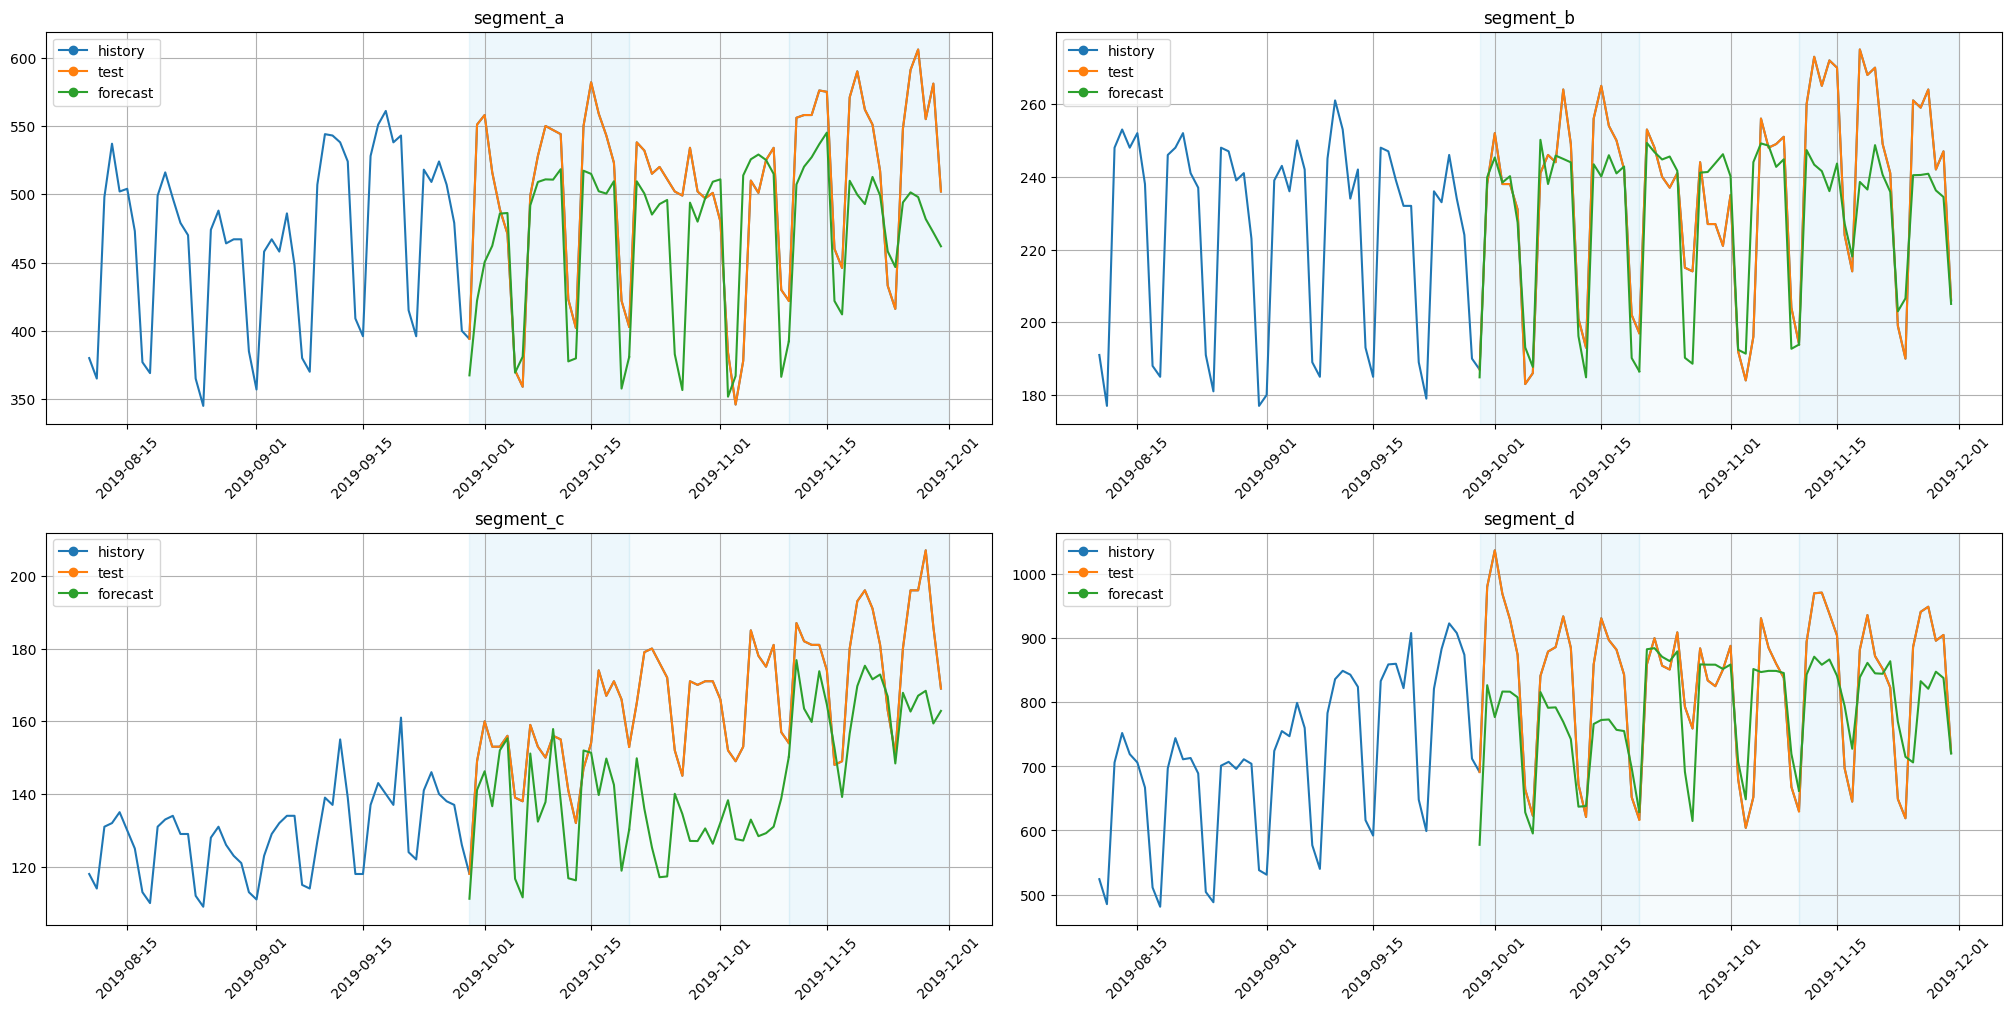

In [10]:
plot_backtest(forecast_df=forecast_df, ts=ts, history_len=50)

Components could be plotted with the function `plot_forecast_decomposition`.

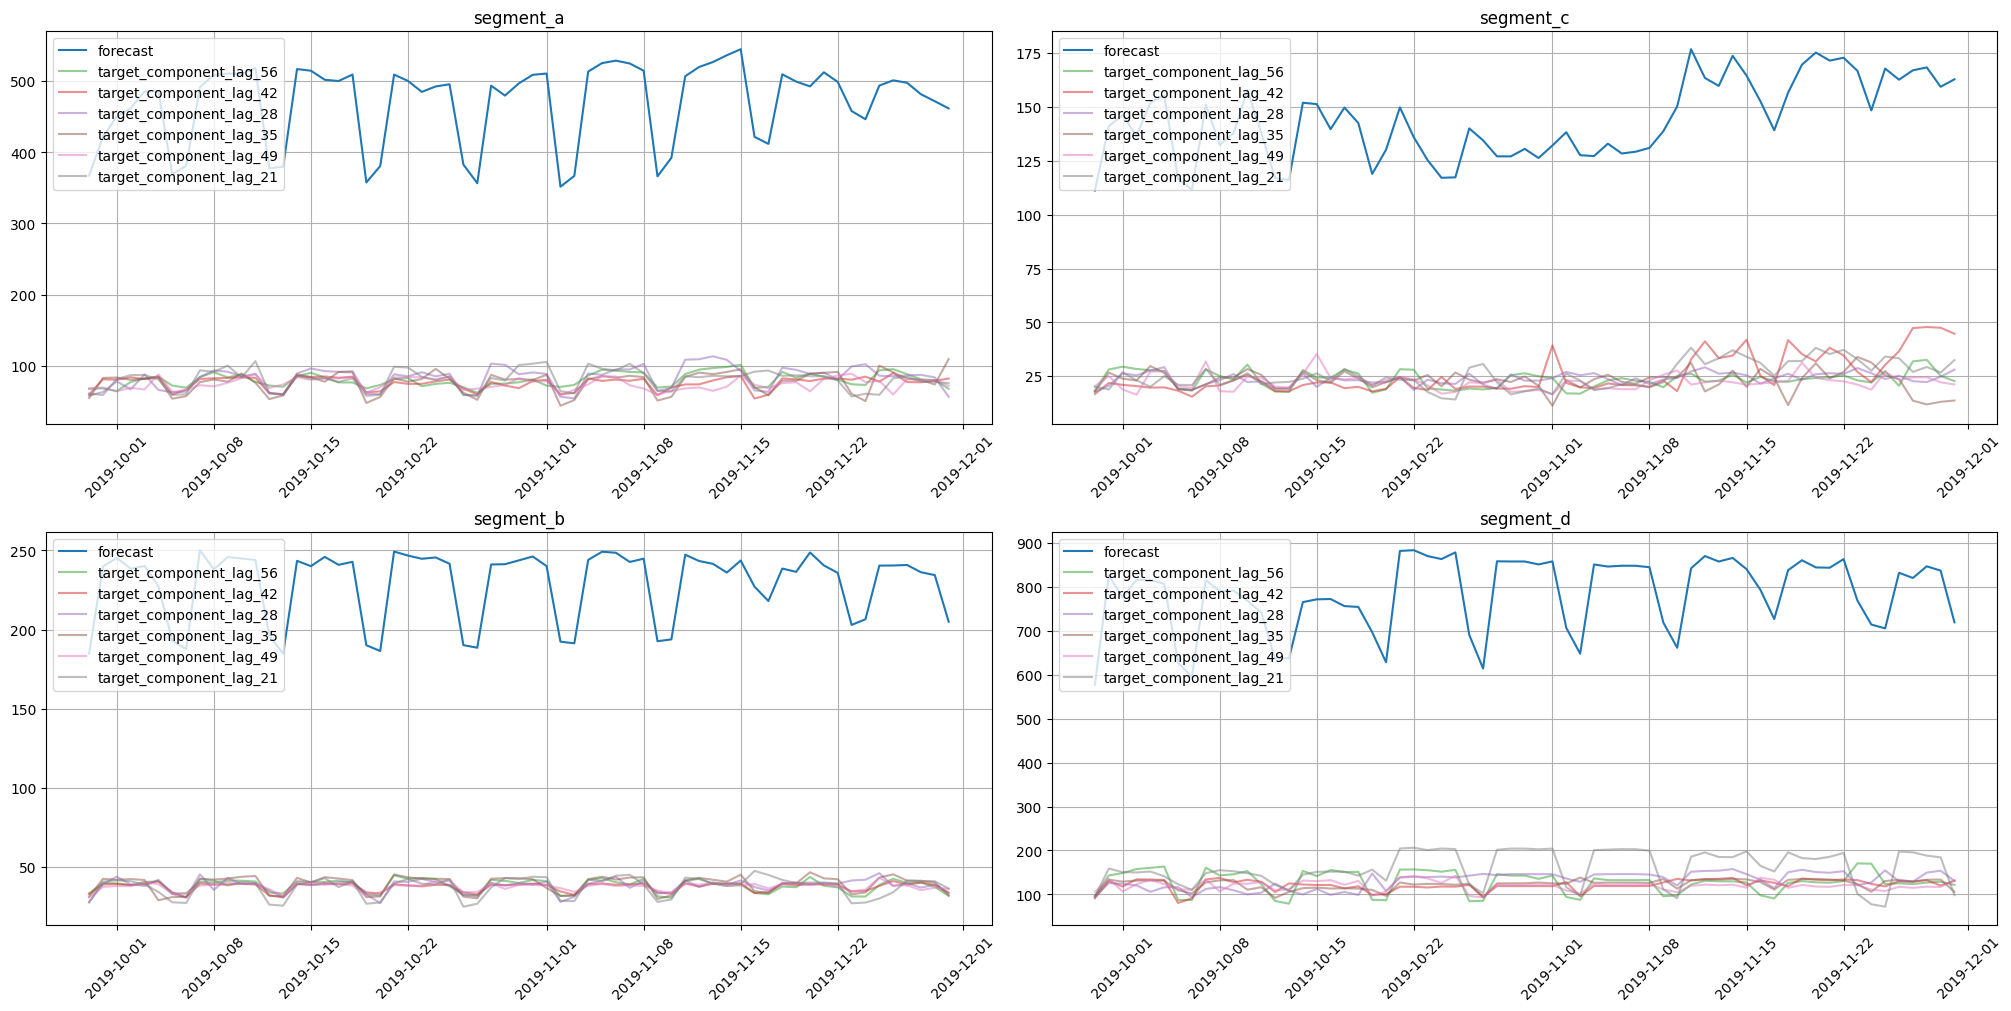

In [11]:
forecast_ts = target_components_to_ts(df=forecast_df)
plot_forecast_decomposition(forecast_ts=forecast_ts, mode="joint", columns_num=2, show_grid=True)

On these charts we can see how each feature contributed to the forecast for each timestamp.
CatBoost uses features to estimate forecasts, so each forecast component corresponds to a particular feature.

Let's run a similar procedure for `CatBoostMultiSegmentModel`.

In [12]:
pipeline = Pipeline(model=CatBoostMultiSegmentModel(), transforms=transforms, horizon=HORIZON)

_, forecast_df, _ = pipeline.backtest(ts=ts, metrics=[MAE()], n_folds=3, forecast_params={"return_components": True})

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s


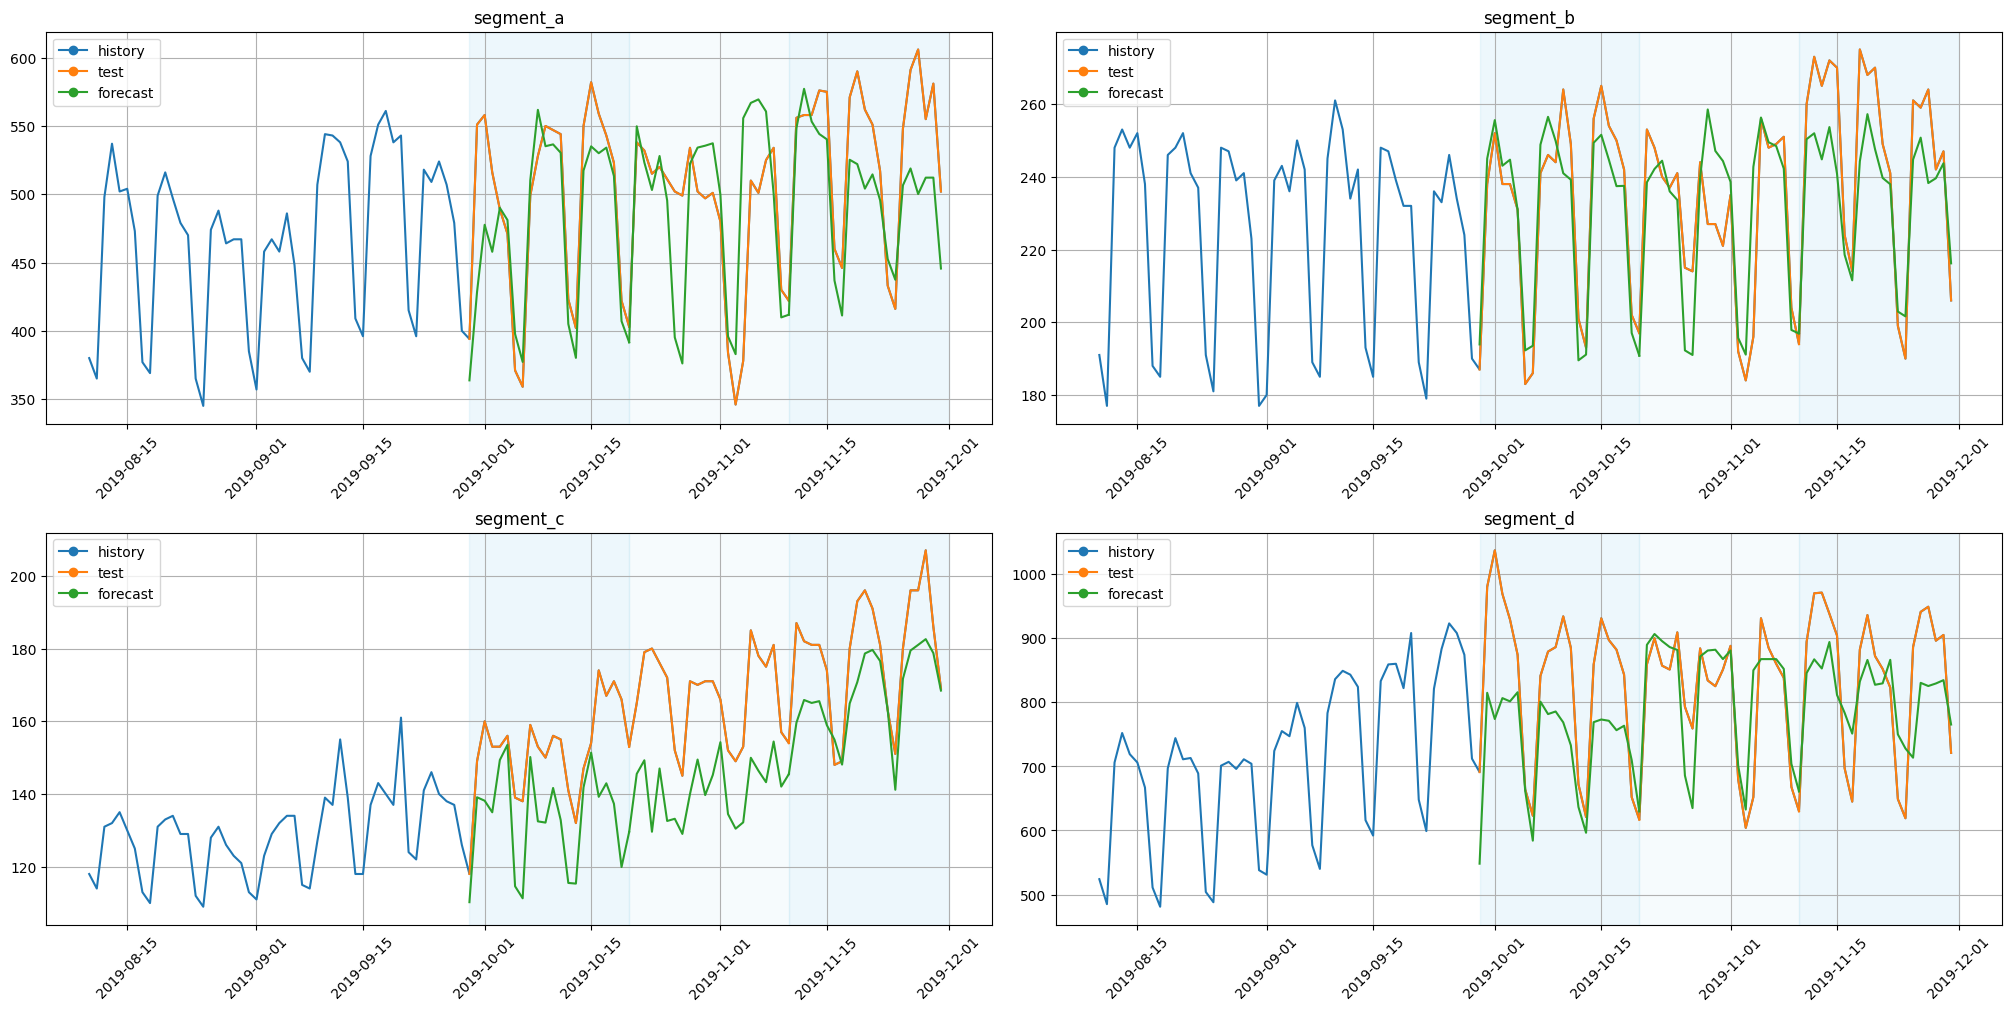

In [13]:
plot_backtest(forecast_df=forecast_df, ts=ts, history_len=50)

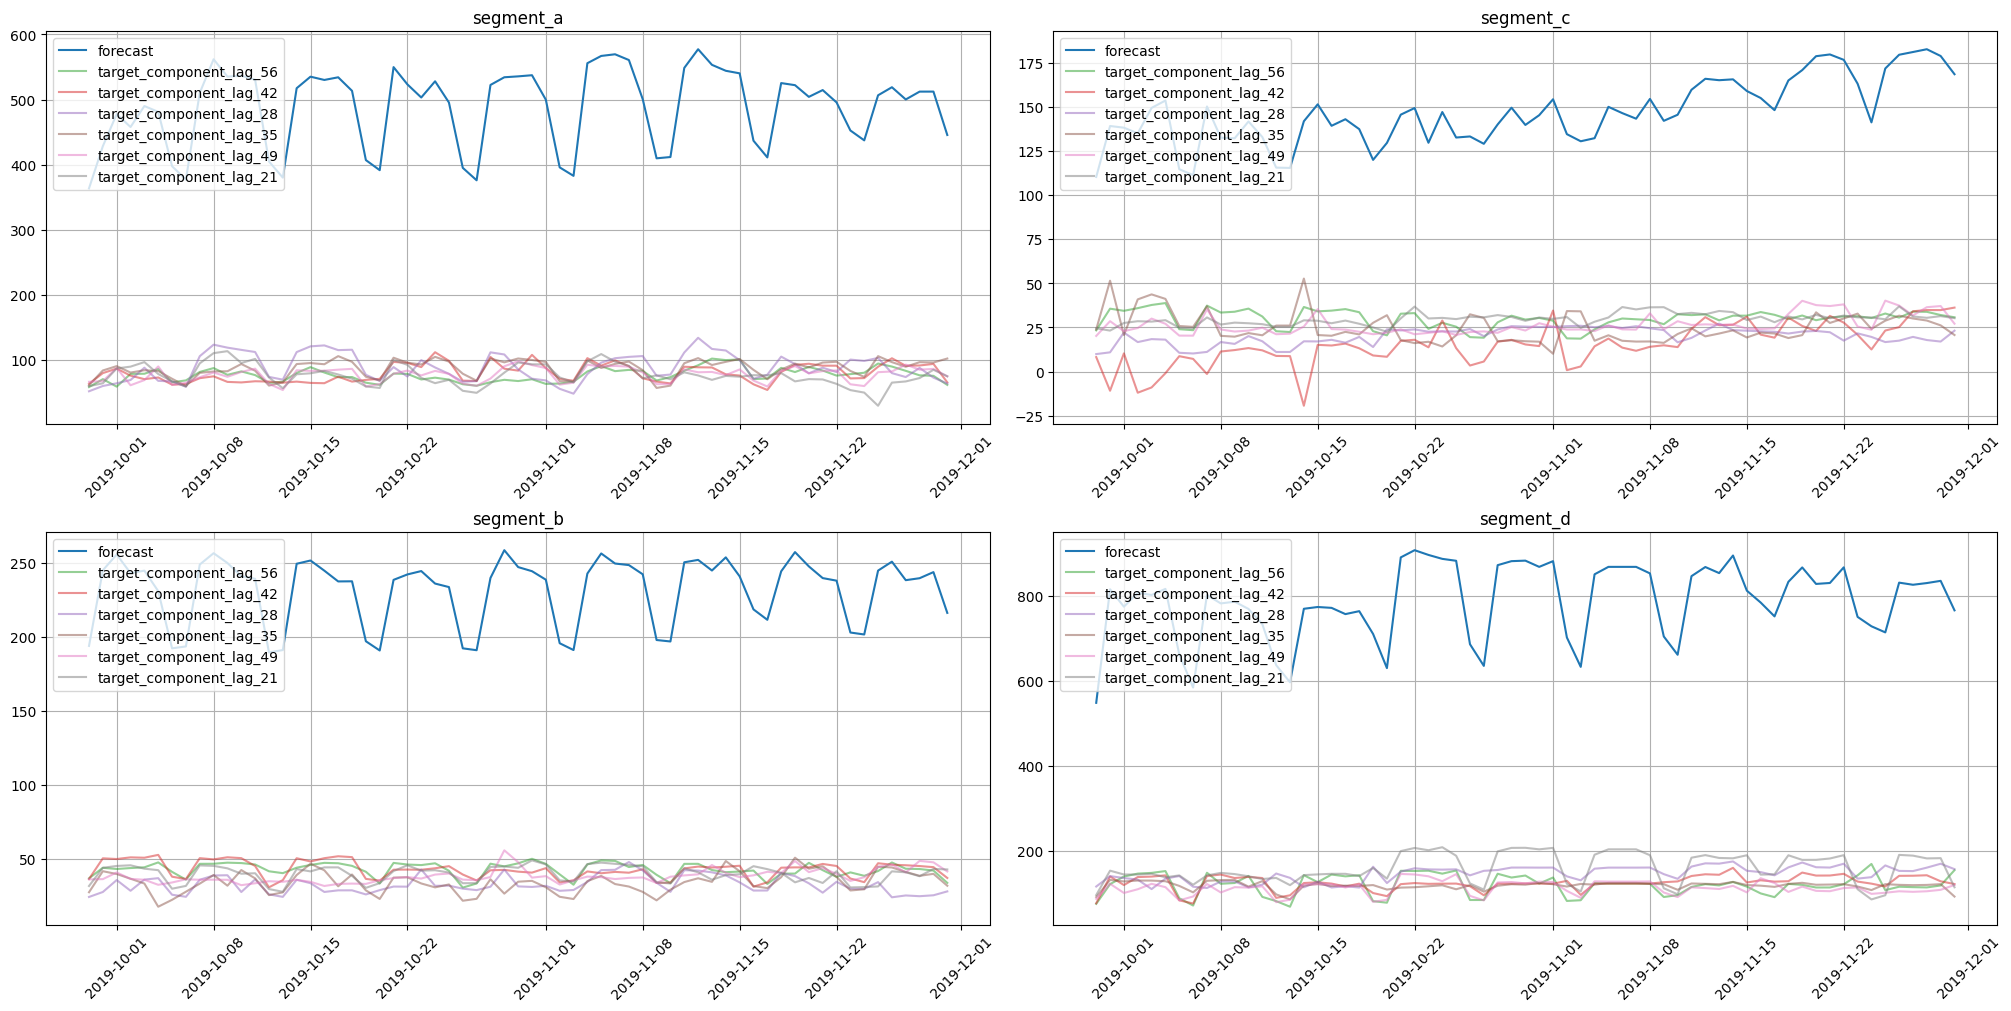

In [14]:
forecast_ts = target_components_to_ts(df=forecast_df)
plot_forecast_decomposition(forecast_ts=forecast_ts, mode="joint", columns_num=2, show_grid=True)

Here we obtained almost similar results. They are identical in structure but slightly different when comparing values.
Such behaviour is explained by the use of a single model for all dataset segments.

## 2.2 SARIMAX <a class="anchor" id="chapter2_2"></a>
SARIMAX uses model-specific forecast decomposition. So the main components of this model are: SARIMA
and effects from exogenous variables.

Such constraints on decomposition form are due to implementation details of SARIMAX models,
which are estimated as state-space models.

In [15]:
from etna.models import SARIMAXModel

Let's build `Pipeline` with `SARIMAXModel` and estimate forecast components on backtest.

In [16]:
pipeline = Pipeline(model=SARIMAXModel(), transforms=transforms, horizon=HORIZON)

_, forecast_df, _ = pipeline.backtest(ts=ts, metrics=[MAE()], n_folds=3, forecast_params={"return_components": True})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.90038D+00    |proj g|=  1.65569D-01

At iterate    5    f=  4.85680D+00    |proj g|=  2.10363D-02

At iterate   10    f=  4.85558D+00    |proj g|=  4.19482D-03

At iterate   15    f=  4.85420D+00    |proj g|=  2.79606D-02

At iterate   20    f=  4.85376D+00    |proj g|=  7.24822D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     22     27      1     0     0   1.529D-05   4.854D+00
  F =   4.8537570835596506     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.34706D+00    |proj g|=  1.90556D-02

At iterate    5    f=  5.34701D+00    |proj g|=  8.87463D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      5      8      1     0     0   8.875D-05   5.347D+00
  F =   5.3470110236236659     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.4s
 This problem is unconstrained.


At iterate    5    f=  4.82551D+00    |proj g|=  4.04983D-02

At iterate   10    f=  4.82384D+00    |proj g|=  3.86702D-03

At iterate   15    f=  4.82355D+00    |proj g|=  1.76847D-02

At iterate   20    f=  4.82168D+00    |proj g|=  5.25136D-03

At iterate   25    f=  4.82166D+00    |proj g|=  1.07272D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     25     31      1     0     0   1.073D-04   4.822D+00
  F =   4.8216622881090307     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.31323D+00    |proj g|=  2.61433D-02

At iterate    5    f=  5.31314D+00    |proj g|=  8.69485D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      5      8      1     0     0   8.695D-05   5.313D+00
  F =   5.3131410159230246     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 v

[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.8s
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.90986D+00    |proj g|=  2.31991D-01

At iterate    5    f=  4.86531D+00    |proj g|=  1.31344D-02

At iterate   10    f=  4.86491D+00    |proj g|=  1.14106D-02

At iterate   15    f=  4.86340D+00    |proj g|=  3.90127D-02

At iterate   20    f=  4.86307D+00    |proj g|=  2.96271D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     23     28      1     0     0   5.929D-05   4.863D+00
  F =   4.8630726840600804     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s


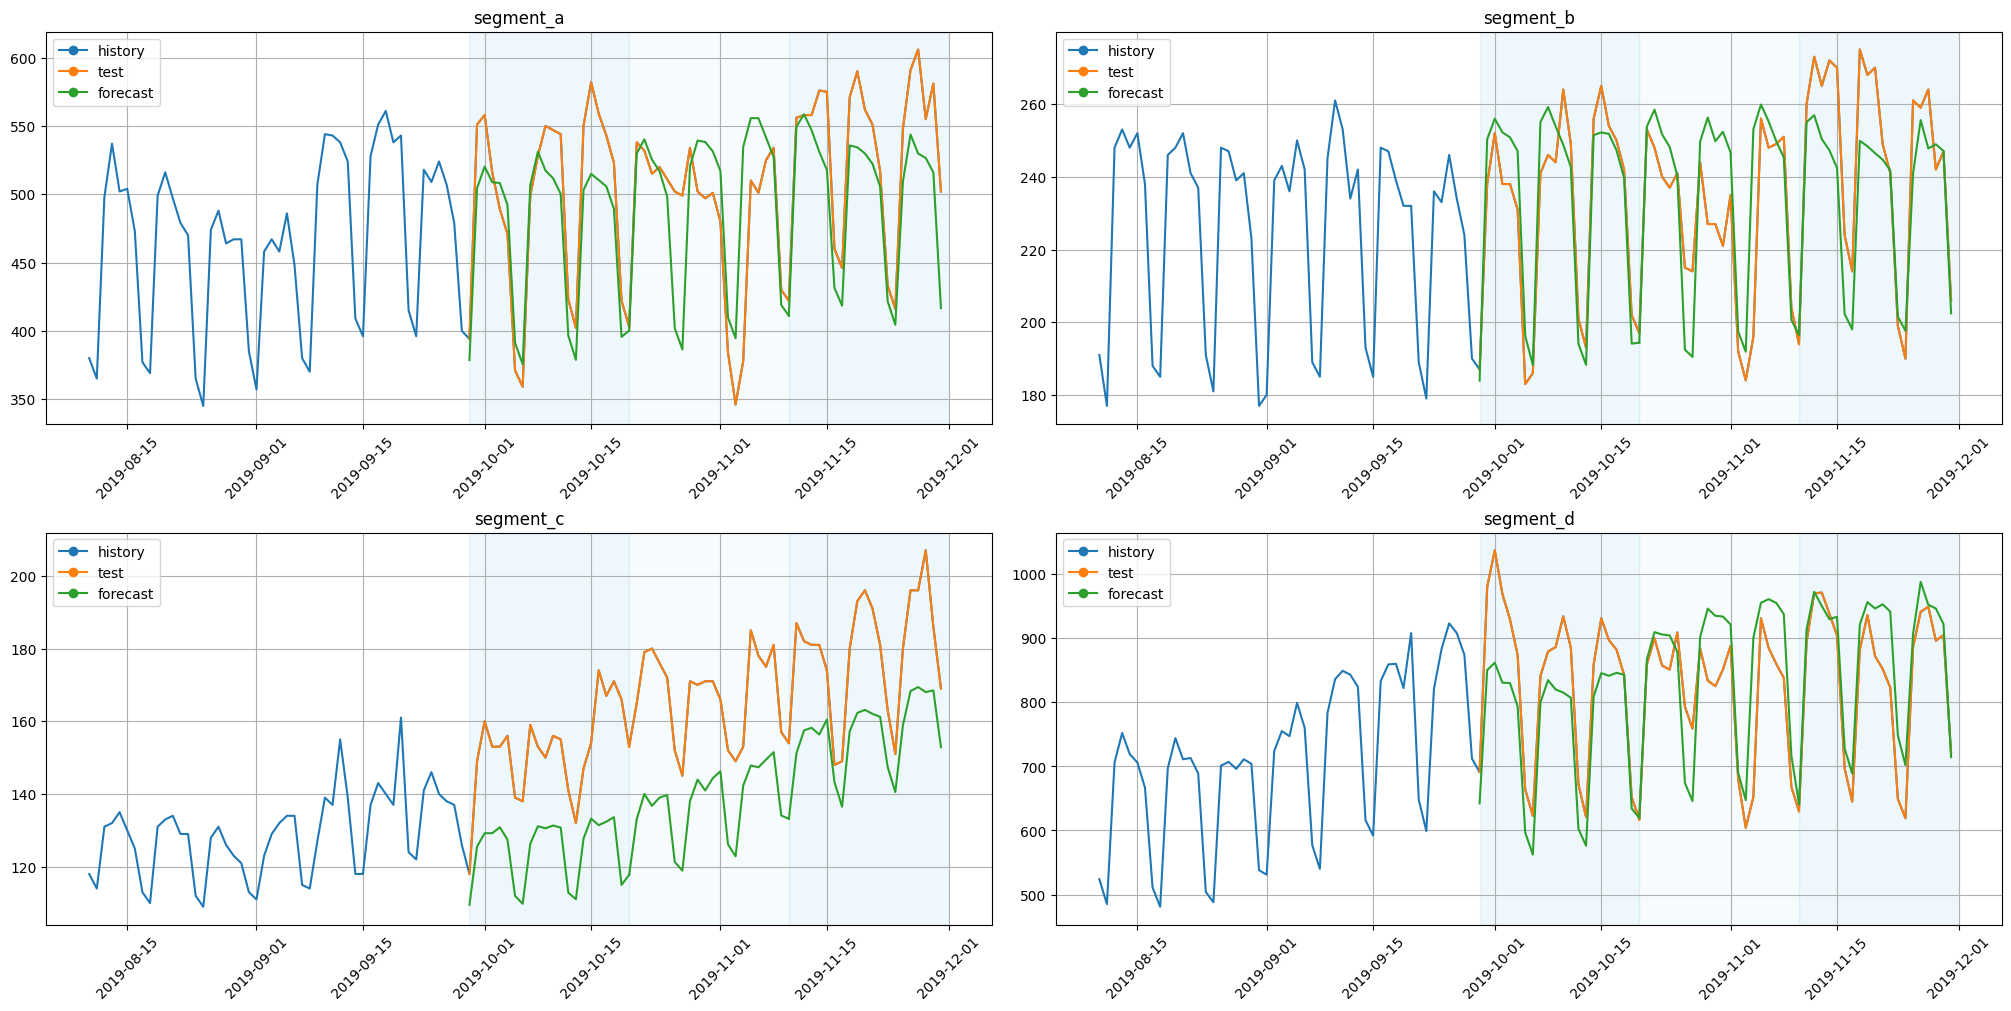

In [17]:
plot_backtest(forecast_df=forecast_df, ts=ts, history_len=50)

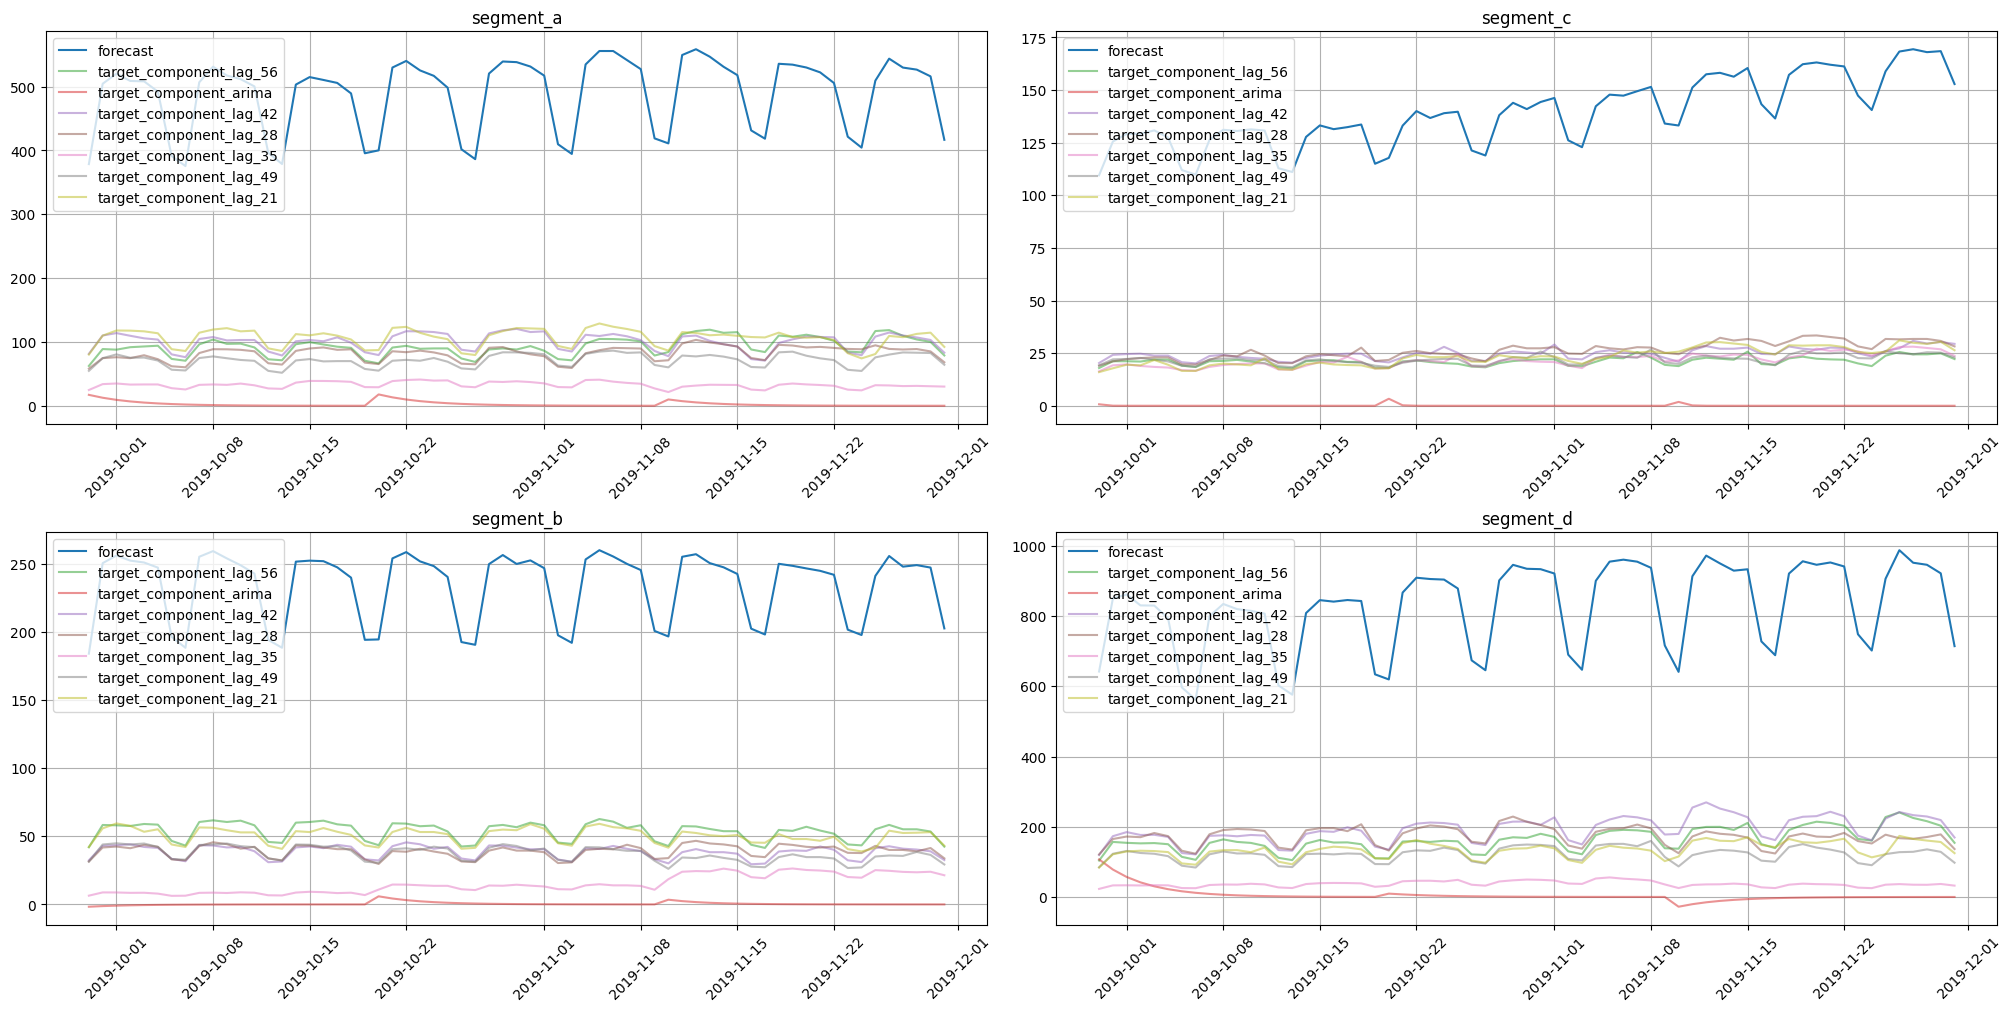

In [18]:
forecast_ts = target_components_to_ts(df=forecast_df)
plot_forecast_decomposition(forecast_ts=forecast_ts, mode="joint", columns_num=2, show_grid=True)

Here we can notice components for each exogenous variable and a separate component for the SARIMA effect.
Note that this decomposition is completely different from the forecast decomposition of CatBoost models,
even on the same data. This is due to different approaches for component contribution estimation.

## 2.3 BATS <a class="anchor" id="chapter2_3"></a>
BATS uses model-specific forecast decomposition. The main components are:
* trend
* local level
* seasonality for each specified period
* errors ARMA(p, q)

The last two components are controlled by `seasonal_periods` and `use_arma_erros` parameters, respectively.
The trend component is controlled by `use_trend`. These parameters add flexibility to the model representation and,
hence, to the forecast decomposition.

In [19]:
from etna.models import BATSModel

Let's build `Pipeline` and estimate forecast decomposition with `BATSModel`, but now without any features.

In [20]:
pipeline = Pipeline(model=BATSModel(seasonal_periods=[14, 21]), horizon=HORIZON)

_, forecast_df, _ = pipeline.backtest(ts=ts, metrics=[MAE()], n_folds=3, forecast_params={"return_components": True})

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  3.0min
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  6.5min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  9.8min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  9.8min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s


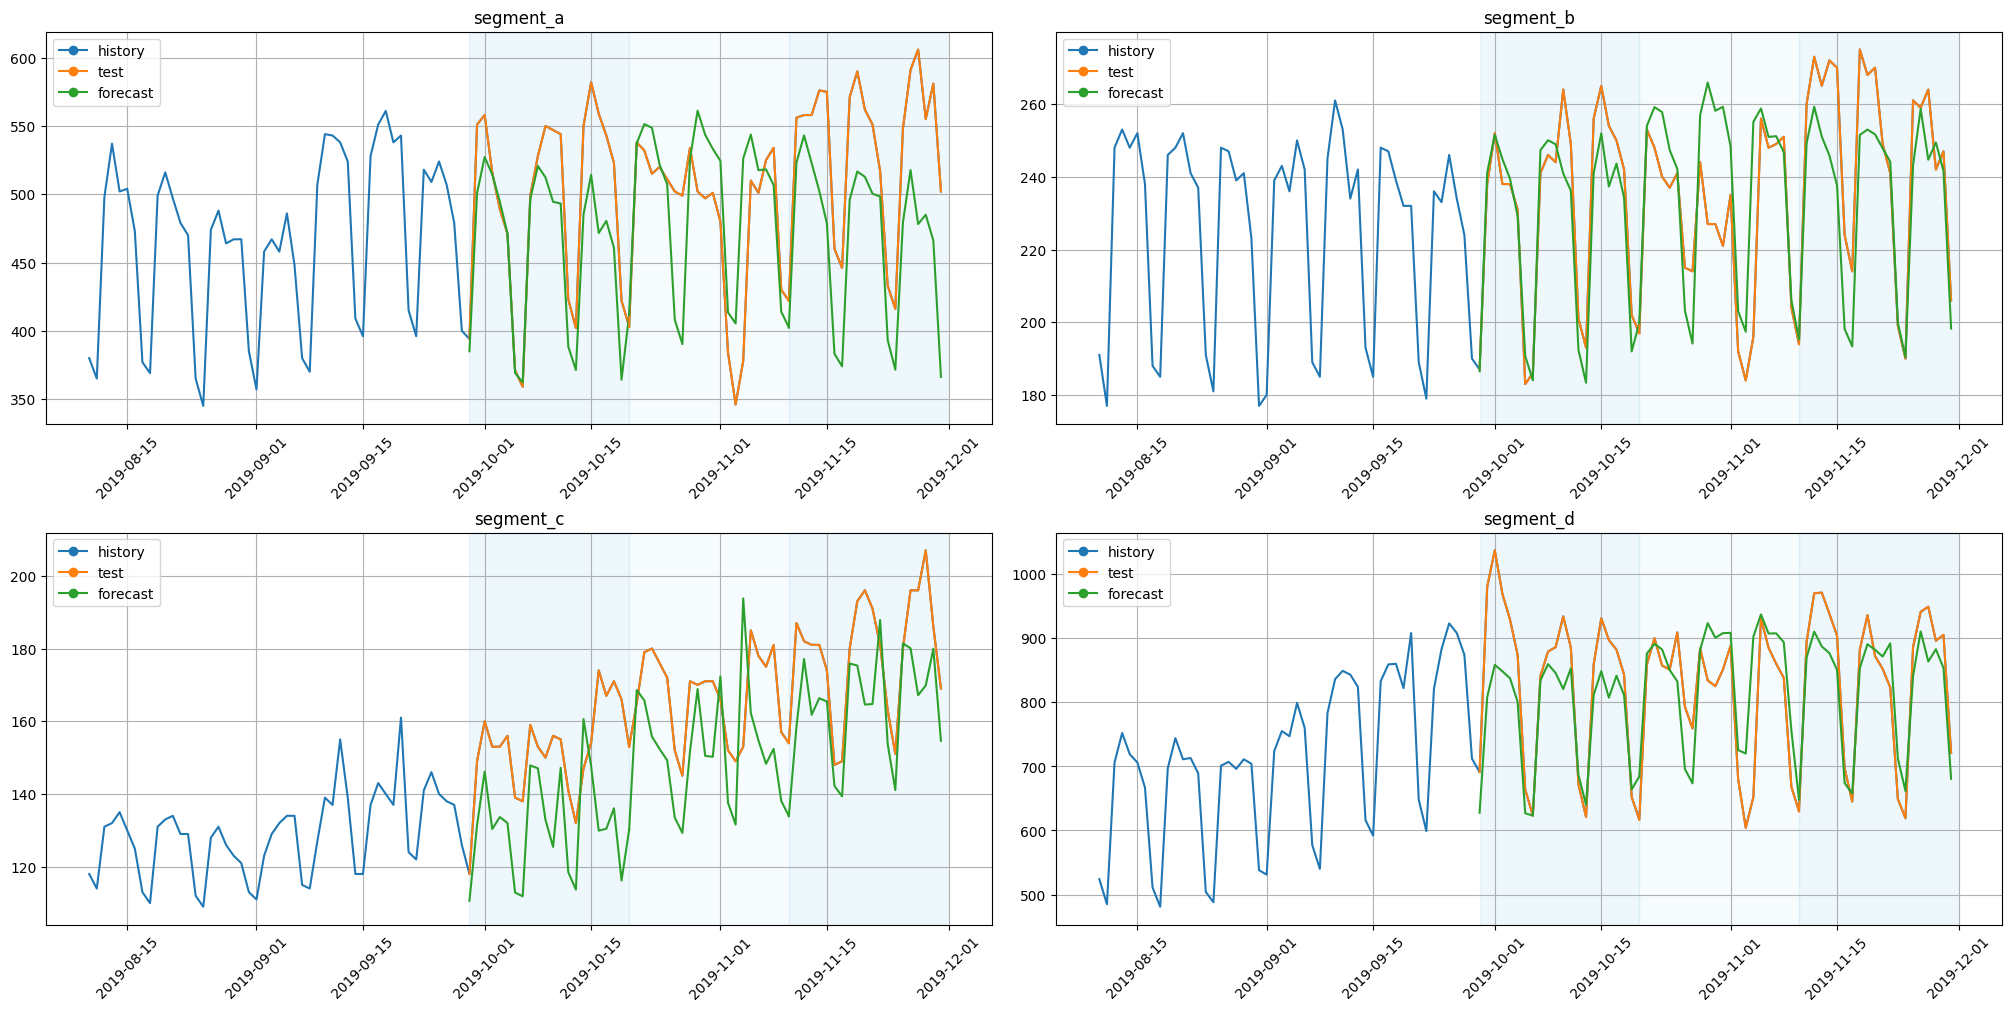

In [21]:
plot_backtest(forecast_df=forecast_df, ts=ts, history_len=50)

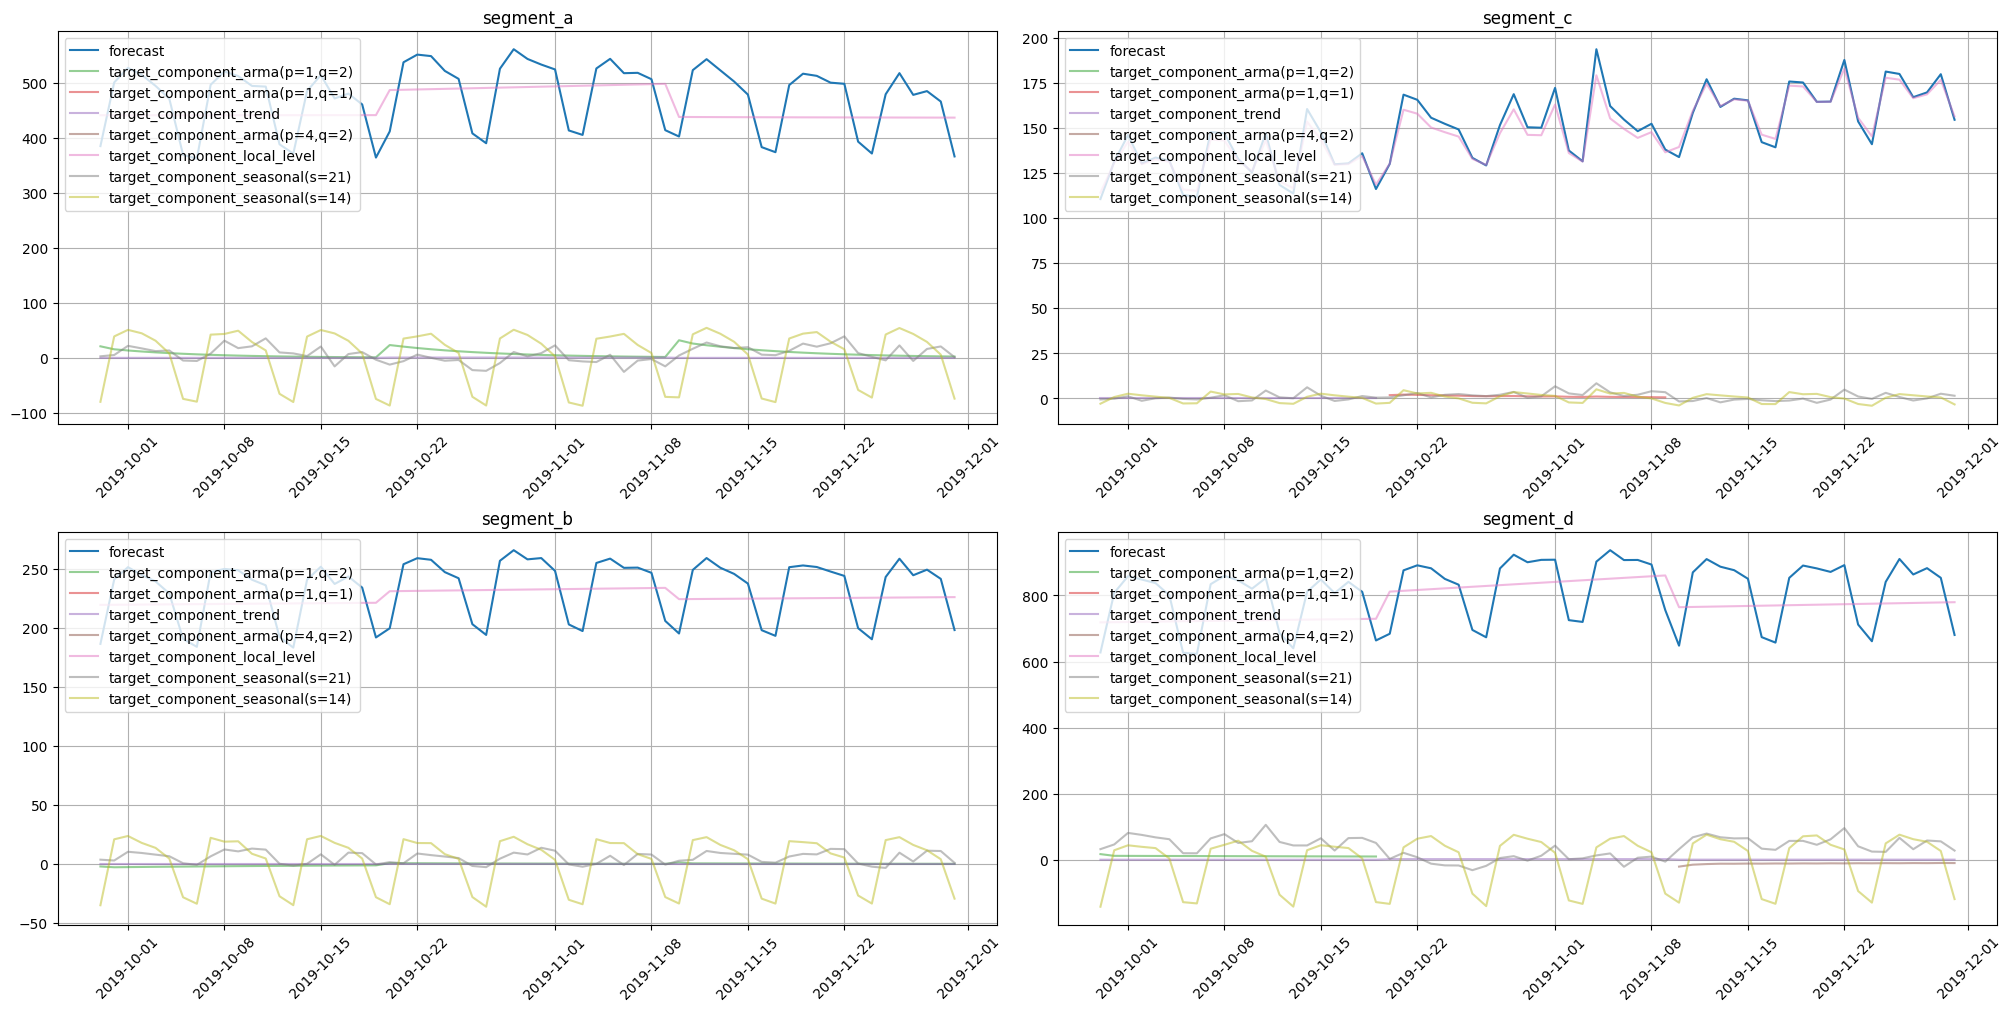

In [22]:
forecast_ts = target_components_to_ts(df=forecast_df)
plot_forecast_decomposition(forecast_ts=forecast_ts, mode="joint", columns_num=2, show_grid=True)

Here we obtained components for trend, local level, seasonality, and ARMA errors. Note that each seasonality
period is represented by a separate component. Such a form of decomposition helps to find causality with
seasonal effects in the original data. Results show that almost all seasonal fluctuations come from
seasonality in period 14.

## 2.4 In-sample and out-of-sample decomposition <a class="anchor" id="chapter2_4"></a>
In the ETNA library we can perform decomposition of fitted and forecasted values separately.

Consider the BATS model with seasonal periods of 2 and 3 weeks.
Let's prepare data for training and forecasting and fit the model.

In [23]:
train, _ = ts.train_test_split(test_size=HORIZON)
future = train.make_future(future_steps=HORIZON)

model = BATSModel(seasonal_periods=[14, 21])
model.fit(ts=train);

In-sample forecast decomposition could be estimated with `predict` method. To do this set `return_components=True`.

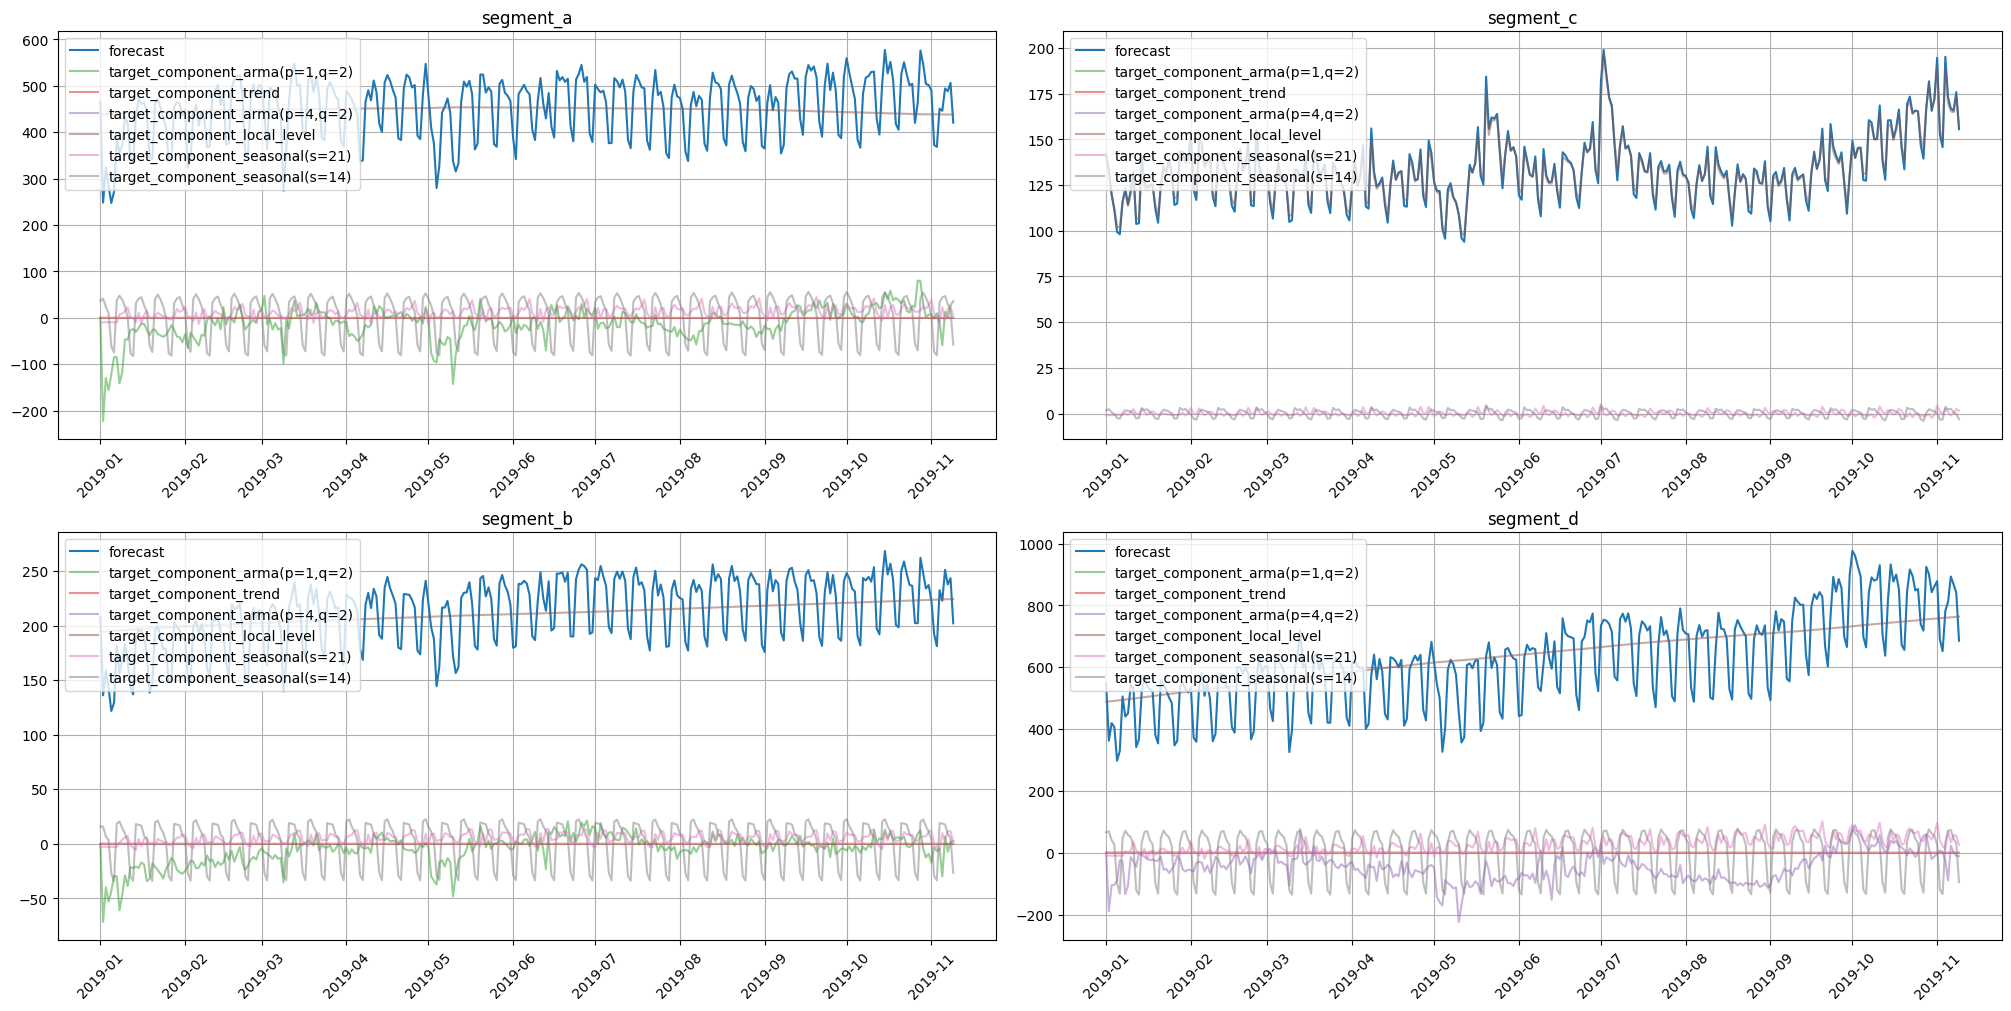

In [24]:
in_sample_forecast = model.predict(ts=train, return_components=True)
plot_forecast_decomposition(forecast_ts=in_sample_forecast, mode="joint", columns_num=2, show_grid=True)

For estimation of out-of-sample forecast decomposition, use `forecast` with `return_components=True`.

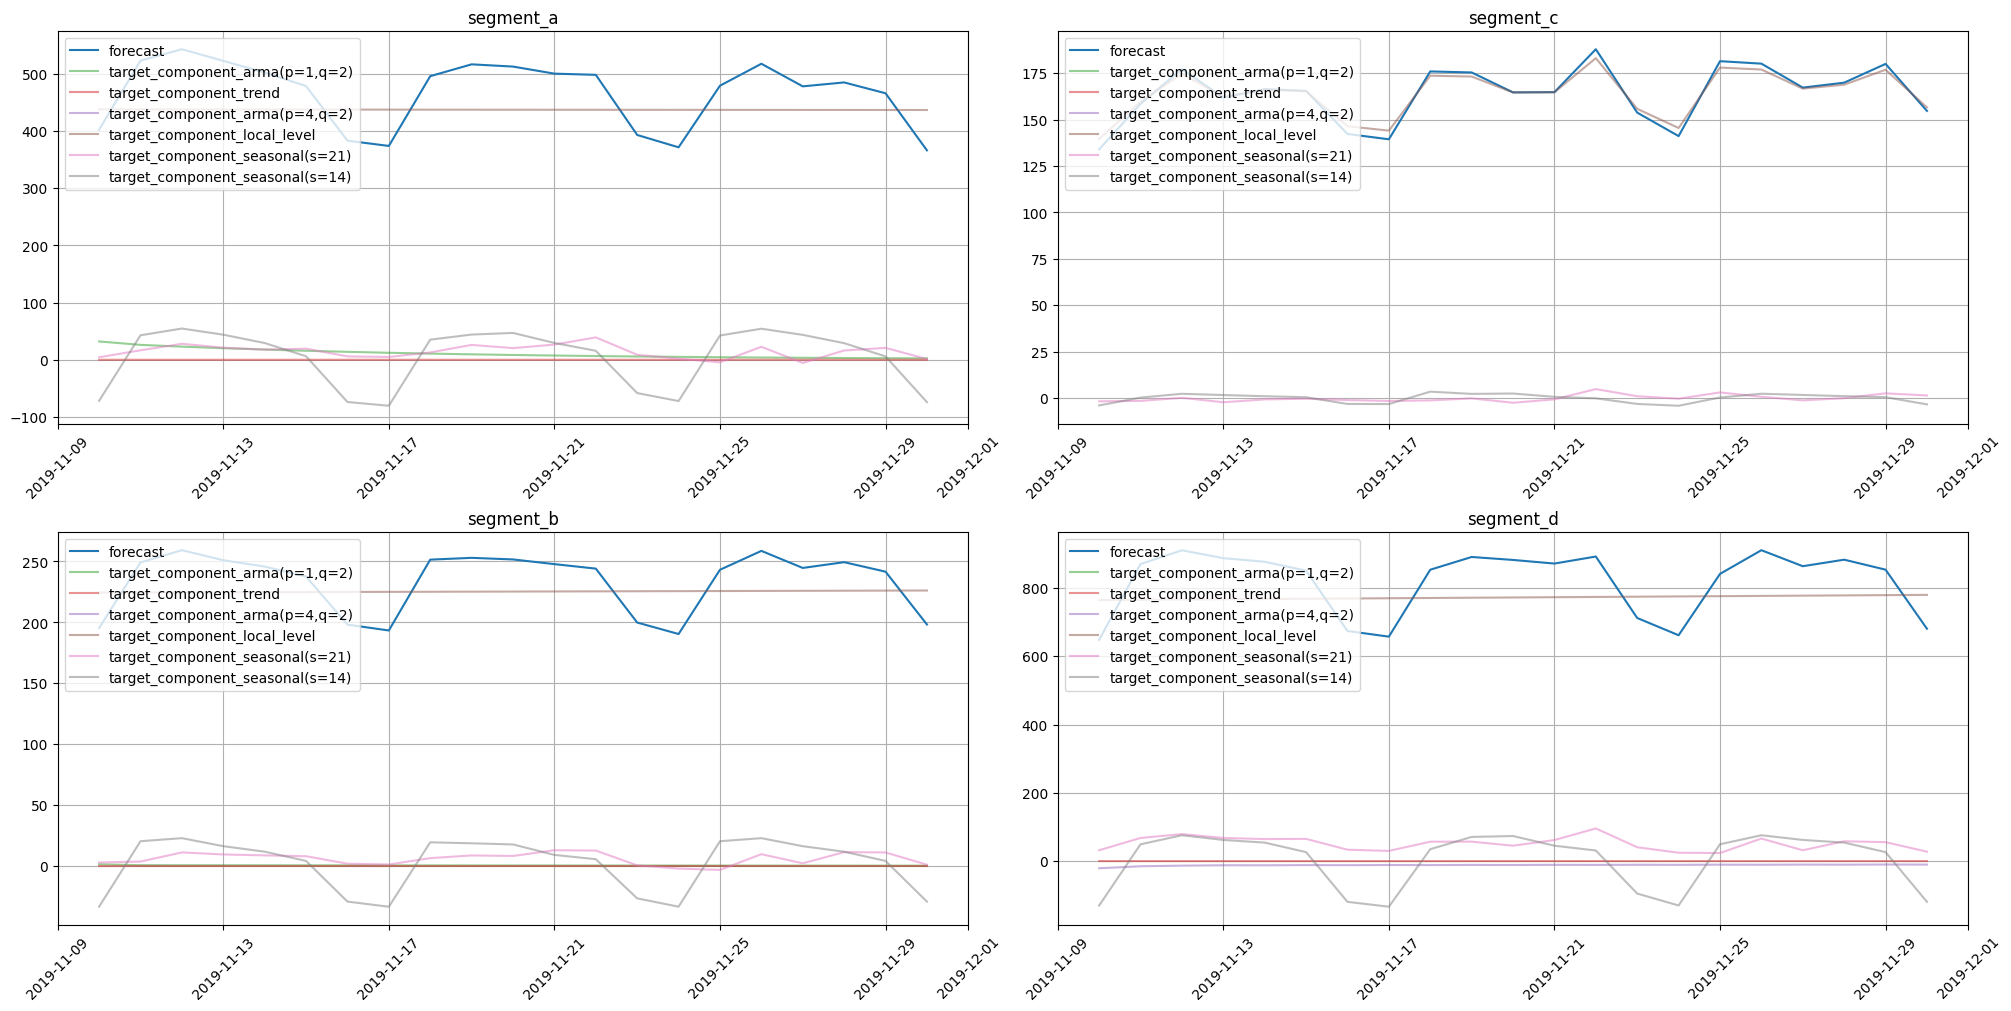

In [25]:
out_of_sample_forecast = model.forecast(ts=future, return_components=True)
plot_forecast_decomposition(forecast_ts=out_of_sample_forecast, mode="joint", columns_num=2, show_grid=True)

As expected, the decomposition form is the same for in-sample and out-of-sample cases.

## 3. Accessing target components <a class="anchor" id="chapter3"></a>
This section shows how one can manipulate forecast components using the `TSDataset` interface.

Let's populate our data with lag features and fit the `CatBoostPerSegmentModel`. We will use this setup
to estimate forecast with additive components.

In [26]:
ts_with_lags = deepcopy(ts)
ts_with_lags.fit_transform(transforms=transforms)

model = CatBoostPerSegmentModel()
model.fit(ts=ts_with_lags);

Now we can estimate forecasts with forecast decomposition.

In [27]:
forecast = model.forecast(ts=ts_with_lags, return_components=True)
forecast

segment    segment_a                                                 \
feature       lag_21 lag_28 lag_35 lag_42 lag_49 lag_56      target   
timestamp                                                             
2019-01-01       NaN    NaN    NaN    NaN    NaN    NaN  368.960244   
2019-01-02       NaN    NaN    NaN    NaN    NaN    NaN  368.960244   
2019-01-03       NaN    NaN    NaN    NaN    NaN    NaN  368.960244   
2019-01-04       NaN    NaN    NaN    NaN    NaN    NaN  368.960244   
2019-01-05       NaN    NaN    NaN    NaN    NaN    NaN  368.960244   
...              ...    ...    ...    ...    ...    ...         ...   
2019-11-26     510.0  502.0  532.0  582.0  528.0  558.0  587.562771   
2019-11-27     501.0  497.0  515.0  559.0  550.0  516.0  602.751237   
2019-11-28     525.0  501.0  520.0  543.0  547.0  489.0  556.927263   
2019-11-29     534.0  480.0  511.0  523.0  544.0  471.0  568.569172   
2019-11-30     430.0  384.0  502.0  422.0  423.0  371.0  499.505858   

segment                                                     \
feature    target_component_lag_21 target_component_lag_28   
timestamp                                                    
2019-01-01               52.677657               45.848608   
2019-01-02               52.677657               45.848608   
2019-01-03               52.677657               45.848608   
2019-01-04               52.677657               45.848608   
2019-01-05               52.677657               45.848608   
...                            ...                     ...   
2019-11-26               92.622123               93.063689   
2019-11-27               93.055945               93.196738   
2019-11-28               89.108979               94.226170   
2019-11-29               96.026571               92.935954   
2019-11-30               81.304877               65.772926   

segment                             ... segment_d                             \
feature    target_component_lag_35  ...    lag_42 lag_49  lag_56      target   
timestamp                           ...                                        
2019-01-01               59.139714  ...       NaN    NaN     NaN  440.294693   
2019-01-02               59.139714  ...       NaN    NaN     NaN  440.294693   
2019-01-03               59.139714  ...       NaN    NaN     NaN  440.294693   
2019-01-04               59.139714  ...       NaN    NaN     NaN  440.294693   
2019-01-05               59.139714  ...       NaN    NaN     NaN  440.294693   
...                            ...  ...       ...    ...     ...         ...   
2019-11-26              102.406833  ...     931.0  879.0  1037.0  937.554113   
2019-11-27               98.617847  ...     897.0  886.0   969.0  941.766157   
2019-11-28               90.372332  ...     882.0  934.0   929.0  894.837318   
2019-11-29               88.949103  ...     843.0  885.0   874.0  899.518552   
2019-11-30              113.489016  ...     652.0  672.0   664.0  720.744048   

segment                                                     \
feature    target_component_lag_21 target_component_lag_28   
timestamp                                                    
2019-01-01               58.143024               43.773274   
2019-01-02               58.143024               43.773274   
2019-01-03               58.143024               43.773274   
2019-01-04               58.143024               43.773274   
2019-01-05               58.143024               43.773274   
...                            ...                     ...   
2019-11-26              186.185095              152.507876   
2019-11-27              189.933535              153.970751   
2019-11-28              181.561275              154.268641   
2019-11-29              178.867363              163.091693   
2019-11-30              108.165250              129.946841   

segment                                                     \
feature    target_component_lag_35 target_component_lag_42   
timestamp             

Note that we have additional columns prefixed with `target_component_`. These are individual effects
that contributed to the overall forecast.

One can obtain forecast components separately from other forecast data using `get_target_components`.

In [28]:
forecast.get_target_components()

segment                  segment_a                          \
feature    target_component_lag_21 target_component_lag_28   
timestamp                                                    
2019-01-01               52.677657               45.848608   
2019-01-02               52.677657               45.848608   
2019-01-03               52.677657               45.848608   
2019-01-04               52.677657               45.848608   
2019-01-05               52.677657               45.848608   
...                            ...                     ...   
2019-11-26               92.622123               93.063689   
2019-11-27               93.055945               93.196738   
2019-11-28               89.108979               94.226170   
2019-11-29               96.026571               92.935954   
2019-11-30               81.304877               65.772926   

segment                                                     \
feature    target_component_lag_35 target_component_lag_42   
timestamp                                                    
2019-01-01               59.139714               69.745969   
2019-01-02               59.139714               69.745969   
2019-01-03               59.139714               69.745969   
2019-01-04               59.139714               69.745969   
2019-01-05               59.139714               69.745969   
...                            ...                     ...   
2019-11-26              102.406833              115.592269   
2019-11-27               98.617847              104.375155   
2019-11-28               90.372332               88.756972   
2019-11-29               88.949103               89.018761   
2019-11-30              113.489016               86.668521   

segment                                                     \
feature    target_component_lag_49 target_component_lag_56   
timestamp                                                    
2019-01-01               69.187315               72.360981   
2019-01-02               69.187315               72.360981   
2019-01-03               69.187315               72.360981   
2019-01-04               69.187315               72.360981   
2019-01-05               69.187315               72.360981   
...                            ...                     ...   
2019-11-26               74.912398              108.965459   
2019-11-27              114.013395               99.492157   
2019-11-28              112.596508               81.866302   
2019-11-29              117.011601               84.627183   
2019-11-30               78.966691               73.303827   

segment                  segment_b                          \
feature    target_component_lag_21 target_component_lag_28   
timestamp                                                    
2019-01-01               29.190551               23.342434   
2019-01-02               29.190551               23.342434   
2019-01-03               29.190551               23.342434   
2019-01-04               29.190551               23.342434   
2019-01-05               29.190551               23.342434   
...                            ...                     ...   
2019-11-26               39.646473               41.938191   
2019-11-27               44.803978               42.526073   
2019-11-28               43.636738               39.279155   
2019-11-29               41.949065               38.703364   
2019-11-30               38.118666               33.999578   

segment                                                     ...  \
feature    target_component_lag_35 target_component_lag_42  ...   
timestamp                                                   ...   
2019-01-01               27.285093               28.338942  ...   
2019-01-02               27.285093               28.338942  ...   
2019-01-03               27.285093               28.338942  ...   
2019-01-04               27.285093               28.338942  ...   
2019-01-05               27.285093               28.338

There is a possibility to remove components. It can be achieved using `drop_target_components`.
This function will remove components inplace. We can ensure that our forecast dataset no longer has
any components by using the `target_components_names` property.

In [29]:
components = forecast.get_target_components()
forecast.drop_target_components()
forecast.target_components_names

()

There is a possibility to attach components to the forecast dataset as well.
The main constraint on components is that, being attached, they should sum up to the target at each timestamp.

In [30]:
forecast.add_target_components(components)
forecast.target_components_names

('target_component_lag_21',
 'target_component_lag_28',
 'target_component_lag_35',
 'target_component_lag_42',
 'target_component_lag_49',
 'target_component_lag_56')

## 4. Regressors relevance <a class="anchor" id="chapter4"></a>
This section shows how regressors relevance could be estimated.

There are two types of relevance estimation in the ETNA library
* statistical, based on `tsfresh` (`StatisticsRelevanceTable`)
* model based (`ModelRelevanceTable`)

In [31]:
from sklearn.ensemble import RandomForestRegressor

from etna.analysis import ModelRelevanceTable
from etna.analysis import StatisticsRelevanceTable
from etna.analysis import plot_feature_relevance

### 4.1 Feature relevance <a class="anchor" id="chapter4_1"></a>
The first step is to prepare the data. Here, we only need features and estimated forecasts.

In [32]:
target_with_features = deepcopy(forecast)
target_with_features.drop_target_components()

Let's estimate feature relevance using a statistical approach. Results can be shown with the help of the `plot_feature_relevance` function.

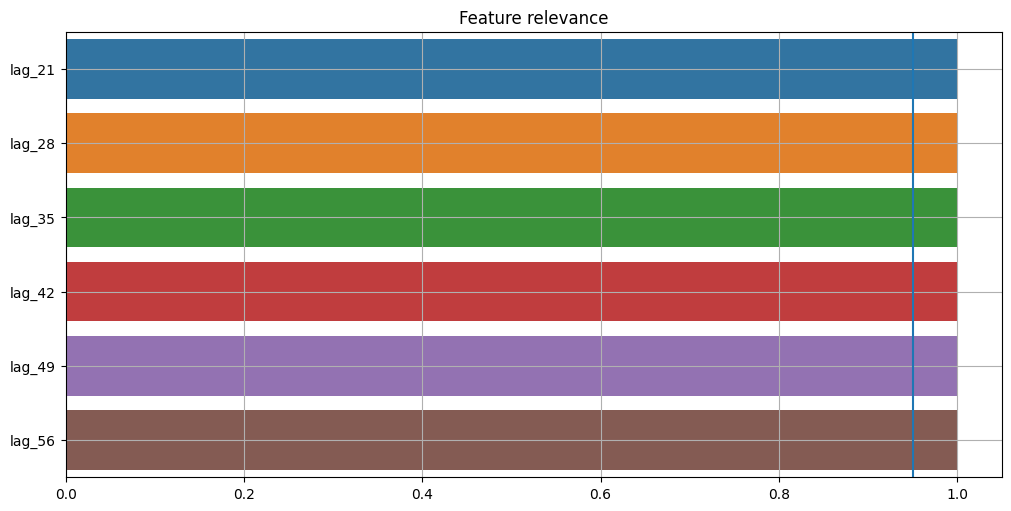

In [33]:
plot_feature_relevance(ts=target_with_features, relevance_table=StatisticsRelevanceTable())

A statistical approach shows that all features have the same relevance. The blue vertical line on the chart
represents the significance level. Values that lie to the right of this line have `p-value < alpha` and
values that lie to the left have `p-value > alpha`. Here we see that all features are significant at the default
level of `alpha = 0.05`. Significance level available only for a statistical approach.

We can use a separate tree-based estimator that is able to provide feature relevance to estimate such values.
In this case, we can use `RandomForestRegressor`.

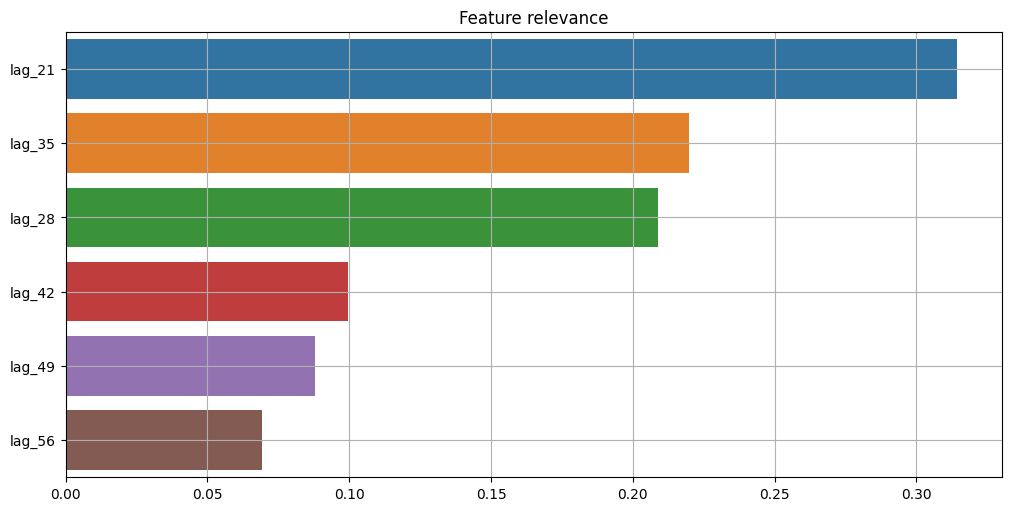

In [34]:
plot_feature_relevance(
    ts=target_with_features,
    relevance_table=ModelRelevanceTable(),
    relevance_params={"model": RandomForestRegressor(random_state=1)},
)

We can see that results from this approach are completely different from statistical results. The main reason is the
relevance estimation process. In `ModelRelevanceTable`, a separate estimator provides `feature_importances_`,
while in `StatisticsRelevanceTable` statistics from `tsfresh` are used.

### 4.2 Components relevance <a class="anchor" id="chapter4_2"></a>
We can use the same instruments to estimate relevance for each target component.

First, let's select only the forecasts with corresponding components from the dataset.

In [35]:
target_with_components = TSDataset(df=forecast[:, :, "target"], freq=forecast.freq)
target_components = forecast.get_target_components()
target_with_components.add_target_components(target_components)

Here we can use the same setup with tree-based relevance estimator.

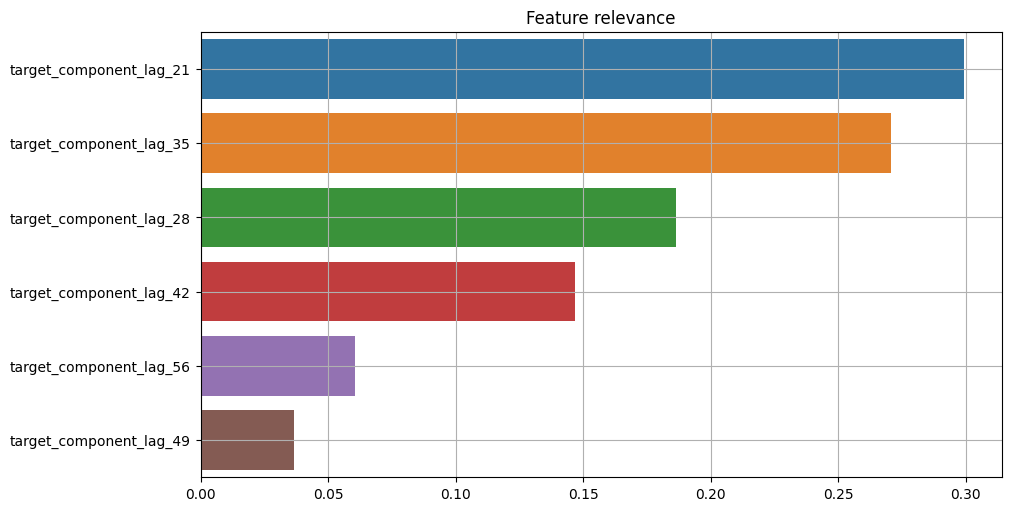

In [36]:
plot_feature_relevance(
    ts=target_with_components,
    relevance_table=ModelRelevanceTable(),
    relevance_params={"model": RandomForestRegressor(random_state=1)},
)

Results show a strong correlation between the relevance of features and the relevance of corresponding components.
Note that values are actually different when comparing components to features relevance.

In this notebook we showed how one can decompose in-sample and out-of-sample forecasts in the ETNA library.
This decomposition has additive properties and hence may be used for forecast interpretation.

Also, we showed how to estimate regressors relevance with different methods and display the results.